# Summary of Findings

### Introduction

The data comes from Purdue University [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks) and
a data dictionary is available at this [article](https://www.sciencedirect.com/science/article/pii/S2352340918307182) under *Table 1. Variable descriptions*.

This dataset contains information about power outages in the US from 2000 to 2016. Each outage contains regional information like the climate region and state that each outage was in. It also has information about the causes of the outages and the extent of the damage they caused. There is also other information about the economics and power consumption of the surrounding area. The question I want to investigate is whether there are certain regions in the US that experience major power outages more frequently than others. By combining the geographical data with the effects of each outage I will explore the distribution of major power outages across the US.

### Cleaning and Exploration
The first step in cleaning the data was to load the correct rows and columns. I used load excel function in pandas with the correct parameters for rows and columns to read the correct data. The next step in cleaning was combining the outage start date and time as well as the end date and time using datetime and string manipulation. 

After that I started to explore the data. I found the columns of customers affected and power lost to best represent the effect of the outage. Customers affected had a right skewed distribution with a mean of 143,456 customers affected per outage. Power lost had a right skewed distribution with a mean of 536 MW lost per outage. The scatterplot between these variables shows that there is a positive association between power lost and customers affected which makes sense because losing more power affects more customers. 

After that I wanted to determine which outages were considered major by the definition of affecting at least 50,000 customers and losing at least 300 MW. About 14% of the outages in the dataset ended up being major outages. When comparing the proportion of outages in each region which were major, the southeast region seemed to have a higher proportion than most with 38.8%, which is over 20% more than the next highest. In contrast, there was a much smaller difference in proportions for climates which had differences less than 3%. Since the difference is proportions of major outages was different for each region, I wanted to test whether the distribution of major outages in the US was significantly different from random chance.

### Assessment of Missingness
Since I wanted to analyze the effects of power outages, I decided to analyze the missingness of demand loss because it directly shows the severity of the outage. The missingness of this column usually happens for severe weather or attacks in which case the power station likely turns off the power themselves rather than it failing. In this case it is possible that the power loss is not automatically recorded whereas it would be in other cases. In addition, the number of people affected varies a lot when demand loss is missing so it is likely not missing in a certain range of values. Therefore the missingness is not NMAR because  other factors have the most influence. 

I set up the first missingness test by first plotting a histogram of customers affected for when demand loss is missing and not missing. Since they have close to the same mean, the KS test statistic is needed to get better differences between samples. I set an alpha level of 0.05 and ran the KS test which gave a p-value of 2.93-40. Since this is less than alpha I reject the null hypothesis. There is sufficient evidence to show that the distribution of people affected is different for missing and not missing values of demand loss. Because of this, it is possible that some outages with missing data could have been considered major when they actually weren't leading to a misrepresentation of the distribution of major outages across America. 

I set up the second missingness test for Industrial Sector Sales the same way as the first and used the KS test again. I set an alpha level of 0.05 and ran the KS test which gave a p-value of 0.18. Since this is more than alpha I don't reject the null hypothesis. There is not sufficient evidence to show that the distribution of Industrial Sector sales is different for missing and not missing values of demand loss. Because of this, states with different amounts of industrializations won't have this affect major outages which improves the accuracy of the hypothesis test.

### Hypothesis Test
I ran a hypothesis test to find out if major outages are uniformly distributed across regions in the United States.

Null Hypothesis: Major outages are uniformly distributed across regions <br>
Alternative Hypothesis: Major outages are not uniformly distributed across regions 

Since the region is a categorical variable, the best test statistic is the TVD of the distribution compared to a uniform distribution. I ran a hypothesis test with 1,000,000 randomly generated distributions of outages with 0.05 as the alpha level. The test resulted in a p-value of 0 which is less than alpha. Therefore, I reject the null hypothesis because there is sufficient evidence that major outages are not uniformly distributed across regions. 

This result shows that one way to improve outages in the US is to only focus on certain regions first because they have a higher proportion of major outages in general. However, the shortcoming of this approach is that it doesn't determine the reason for the outages so it doesn't show exactly how to prevent outages. A way to improve this test is to run a hypothesis test of different causes of outages and see if there is a significant result to determine exactly what to improve.

# Code

In [1]:
# importing packages
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import folium
from scipy.stats import ks_2samp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and Exploration

This cell gets data from 'outage.xlsx' and makes sure it has the correct rows and columns. The output is the first 5 rows.

In [2]:
outages_raw = pd.read_excel('outage.xlsx', header=5, skiprows = lambda x: x==6, usecols = lambda x: x!='variables')
outages_raw.head()

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


This cell creates a DataFrame called 'outages' which has the start and restoration date and times combined into one column.

In [3]:
outages = outages_raw.copy()
# combines dates and times for outage start and end
start = pd.to_datetime(outages['OUTAGE.START.DATE'].dt.date.astype(str) + ' ' + 
                       outages['OUTAGE.START.TIME'].astype(str), errors = 'coerce')
end = pd.to_datetime(outages['OUTAGE.RESTORATION.DATE'].dt.date.astype(str) + ' ' + 
                     outages['OUTAGE.RESTORATION.TIME'].astype(str), errors = 'coerce')
# clean column names
outages = outages.assign(start = start)
outages = outages.assign(end = end)
outages = outages.rename(columns = {'start': 'OUTAGE.START', 'end':'OUTAGE.RESTORATION'})
outages = outages.drop(columns = ['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 
                                  'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'])
outages[['OUTAGE.START', 'OUTAGE.RESTORATION']].head()

,OUTAGE.START,OUTAGE.RESTORATION
0,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2014-05-11 18:38:00,2014-05-11 18:39:00
2,2010-10-26 20:00:00,2010-10-28 22:00:00
3,2012-06-19 04:30:00,2012-06-20 23:00:00
4,2015-07-18 02:00:00,2015-07-19 07:00:00


The 2 cells below show the mean and a histogram of the number of people affected in each power outage.

In [4]:
np.mean(outages['CUSTOMERS.AFFECTED'])

143456.22273143905

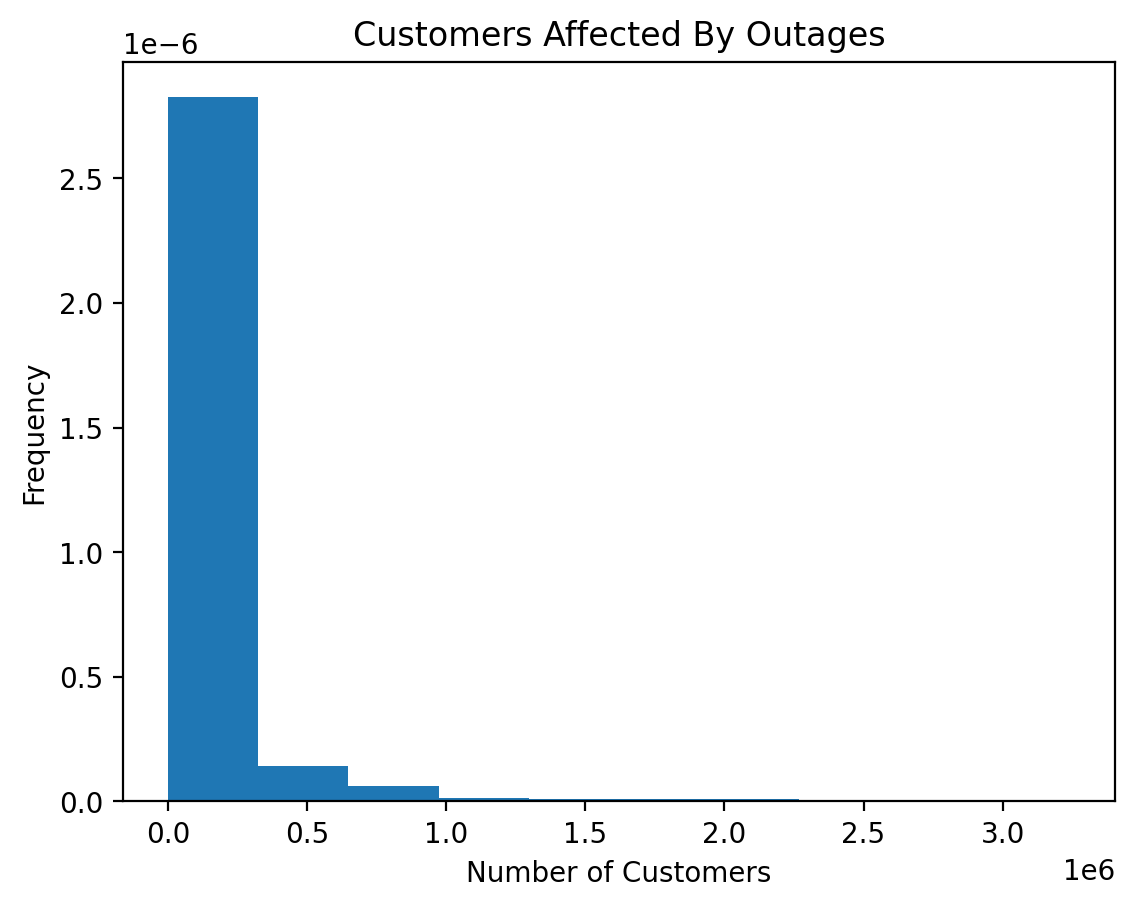

In [5]:
plt.hist(outages['CUSTOMERS.AFFECTED'], density=True)
plt.xlabel('Number of Customers')
plt.ylabel('Frequency')
plt.title('Customers Affected By Outages')
plt.show()

This 2 cells below show the mean and a histogram of the amount of demand lost in megawatts for all outages.

In [6]:
np.mean(outages['DEMAND.LOSS.MW'])

536.2870928829916

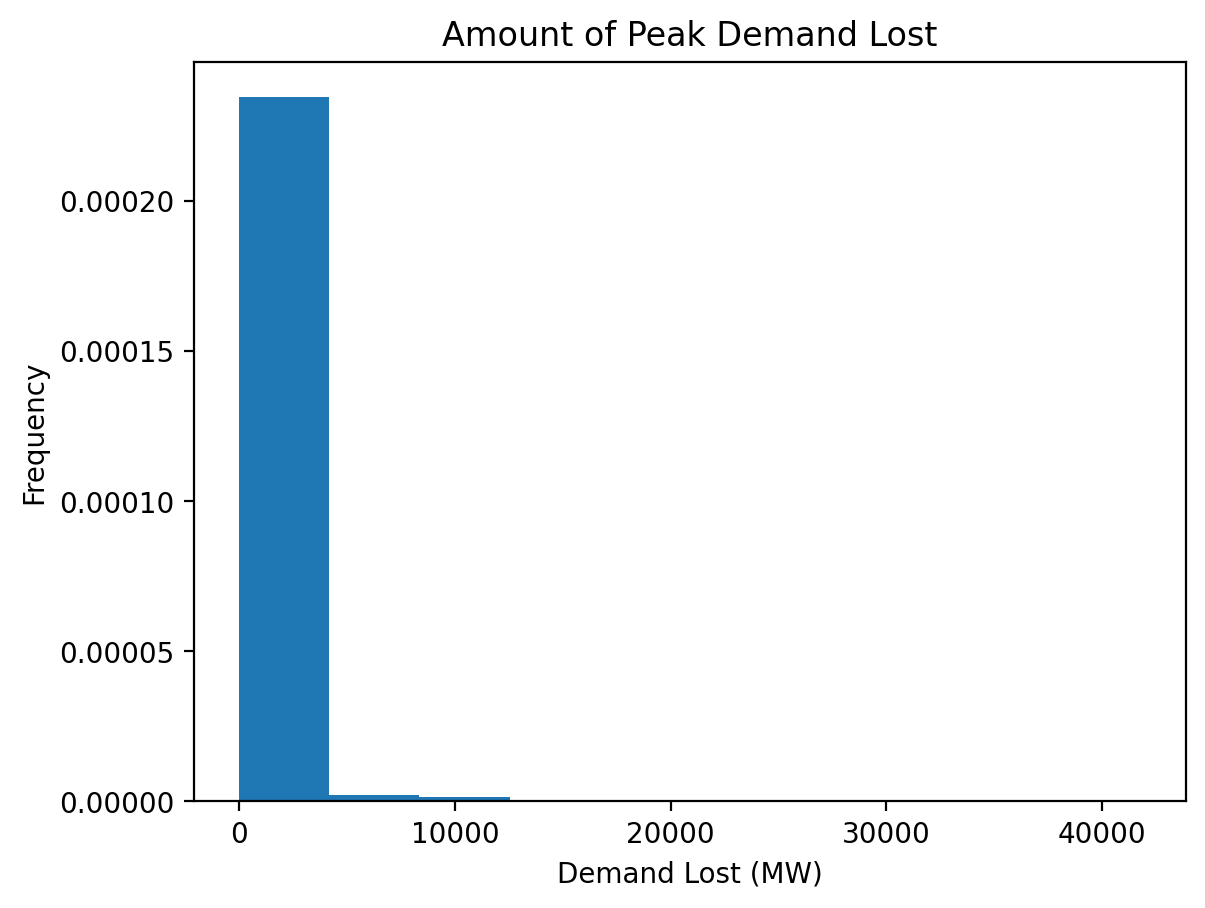

In [7]:
plt.hist(outages['DEMAND.LOSS.MW'], density=True)
plt.xlabel('Demand Lost (MW)')
plt.ylabel('Frequency')
plt.title('Amount of Peak Demand Lost')
plt.show()

Two of the columns that display the severity of the outage are 'CUSTOMERS.AFFECTED' and 'DEMAND.LOSS.MW'. To find associations between these columns, this scatterplot shows the data. This chart shows the slight positive association between customers affected and loss of power so more customers affected generally means more power lost.

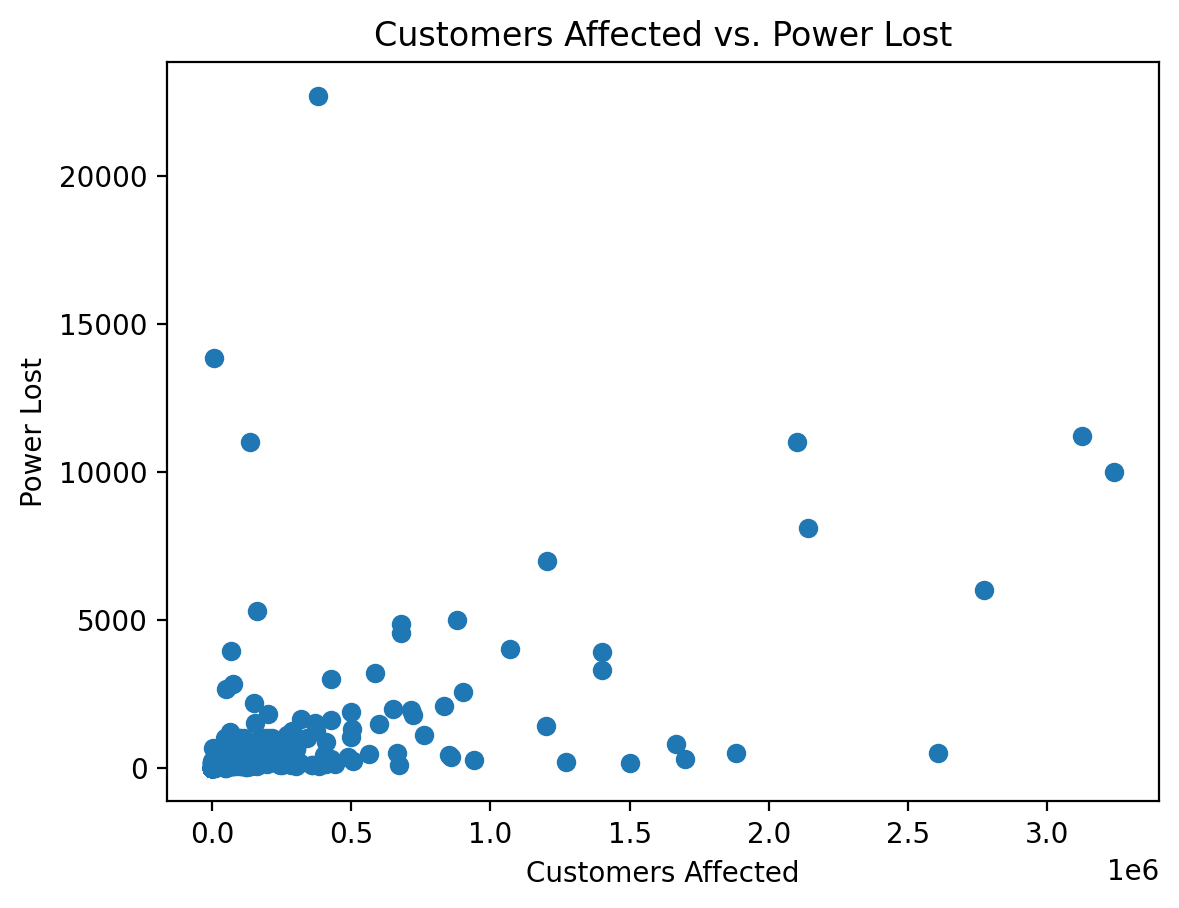

In [8]:
plt.scatter(outages['CUSTOMERS.AFFECTED'], outages['DEMAND.LOSS.MW'])
plt.xlabel('Customers Affected')
plt.ylabel('Power Lost')
plt.title('Customers Affected vs. Power Lost')
plt.show()

Since major outages are when the number of customers affected are greater than 50,000 and the amount of demand lost is greated than 300 MW, it is possible to find out which outages are major. The next cell creates a boolean column called 'MAJOR' to show if an outage is major.

In [9]:
major = outages.assign(MAJOR = (outages['DEMAND.LOSS.MW'] >= 300) & (outages['CUSTOMERS.AFFECTED'] >= 50000))
major['MAJOR'].head()

0    False
1    False
2    False
3    False
4    False
Name: MAJOR, dtype: bool

This cell shows the proportion of major to non major outages. About 86% are not major and 14% are major.

In [10]:
major['MAJOR'].value_counts(normalize=True)

False    0.860495
True     0.139505
Name: MAJOR, dtype: float64

This pivot table shows how different regions and climates have different proportions of major outages compared to all outages. This shows that in general outages are most likely to be major in the southeast region and there is not much difference across climates.

In [11]:
ptable = major.pivot_table('MAJOR', 'CLIMATE.CATEGORY', 'CLIMATE.REGION', 'mean')
ptable

CLIMATE.REGION,Central,East North Central,Northeast,Northwest,South,Southeast,Southwest,West,West North Central
CLIMATE.CATEGORY,,,,,,,,,
cold,0.088235,0.131579,0.080645,0.042553,0.157895,0.355556,0.125000,0.109375,0.200000
normal,0.166667,0.204819,0.105556,0.020408,0.216216,0.309859,0.043478,0.107527,0.142857
warm,0.068966,0.117647,0.088889,0.138889,0.033898,0.500000,0.045455,0.100000,0.000000


The average proportion of major outages across regions shows a much higher amount in the southeast with about 39%.

In [12]:
ptable.mean()['Southeast']

0.388471570161711

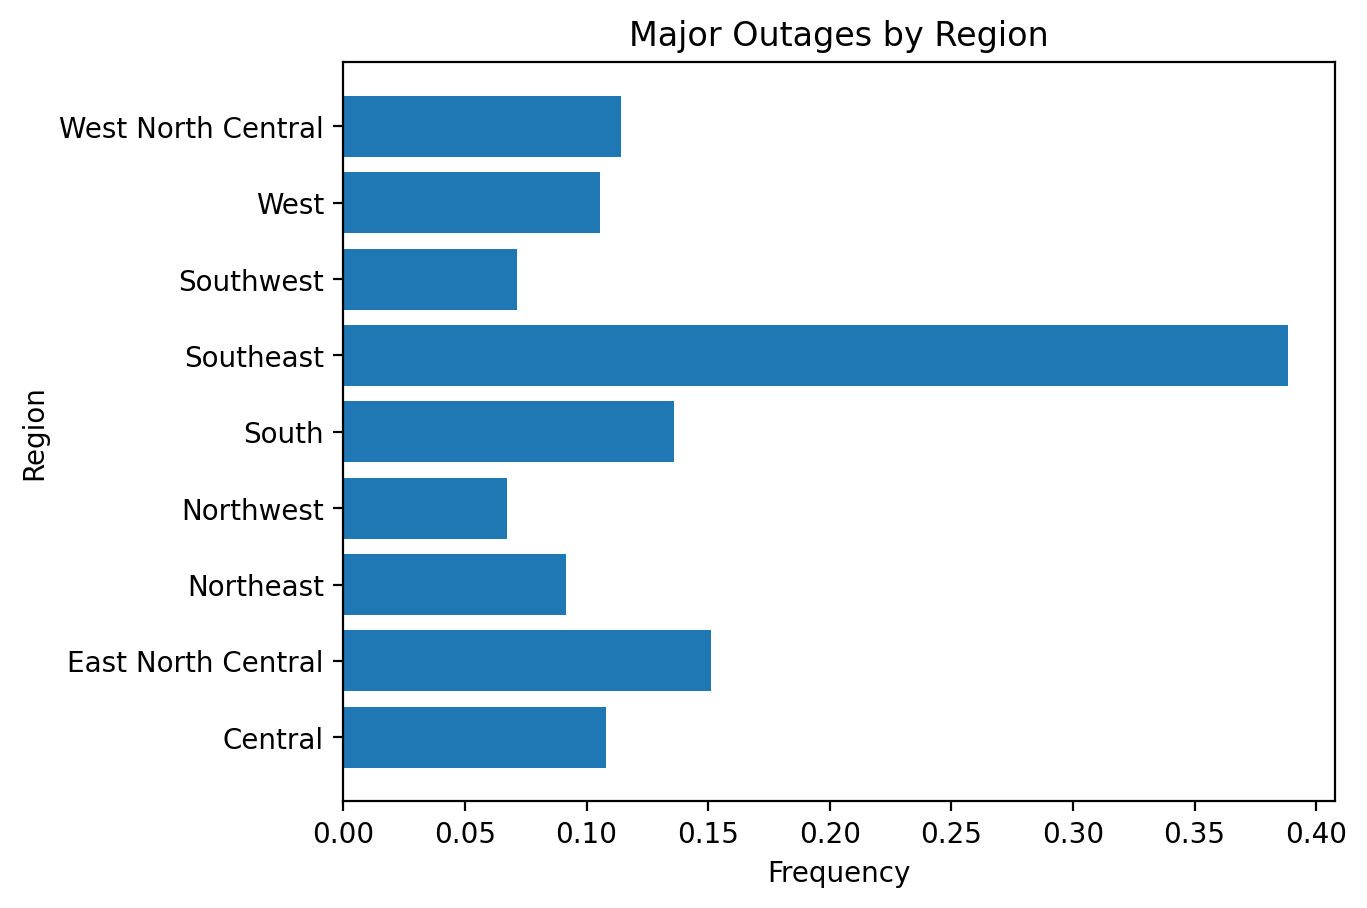

In [13]:
plt.barh(ptable.mean().index, ptable.mean().values)
plt.xlabel('Frequency')
plt.ylabel('Region')
plt.title('Major Outages by Region')
plt.show()

In contrast, the climate category seems to have less of an observable difference between categories with all being around 
12-14%.

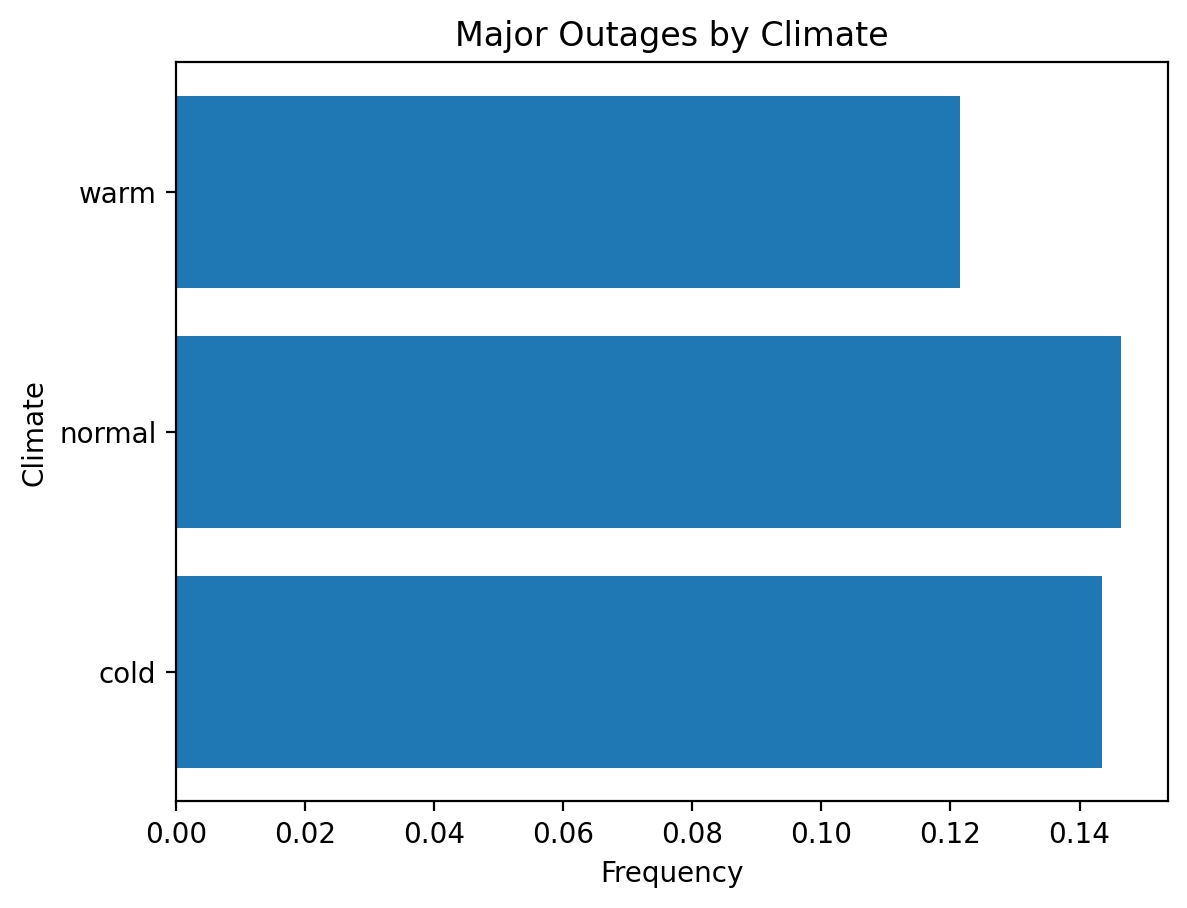

In [14]:
plt.barh(ptable.mean(axis=1).index, ptable.mean(axis=1).values)
plt.xlabel('Frequency')
plt.ylabel('Climate')
plt.title('Major Outages by Climate')
plt.show()

Since major outages by region has a higher observed difference, the next cell looks more into that. This cell more specifically finds the proportion of major outages by state instead of region.

In [15]:
states = major.groupby('POSTAL.CODE')[['MAJOR']].mean().fillna(0).reset_index()
states = states.rename(columns = {'POSTAL.CODE':'state', 'MAJOR': 'major'})
states.head()

,state,major
0,AK,0.000000
1,AL,0.166667
2,AR,0.080000
3,AZ,0.107143
4,CA,0.109524


This cell maps the percent of major outages by state. Like the pivot table shows, the southeast region tends to have a higher proportion of major outages compared to other regions.

In [16]:
m = folium.Map(location=[48, -102], zoom_start=3)
# data for US geography
state_geo = 'us-states.json'
# creates map
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=states,
    columns=["state", "major"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="PERCENT OF MAJOR OUTAGES",
).add_to(m)

folium.LayerControl().add_to(m)
m

### Assessment of Missingness

This cell shows the proportion of missing values for the 10 columns with most data missing. Hurricane names is missing by design because not every outage is due to a hurricane. The next highest is Demand Loss which has nontrivial missingness to analyze.

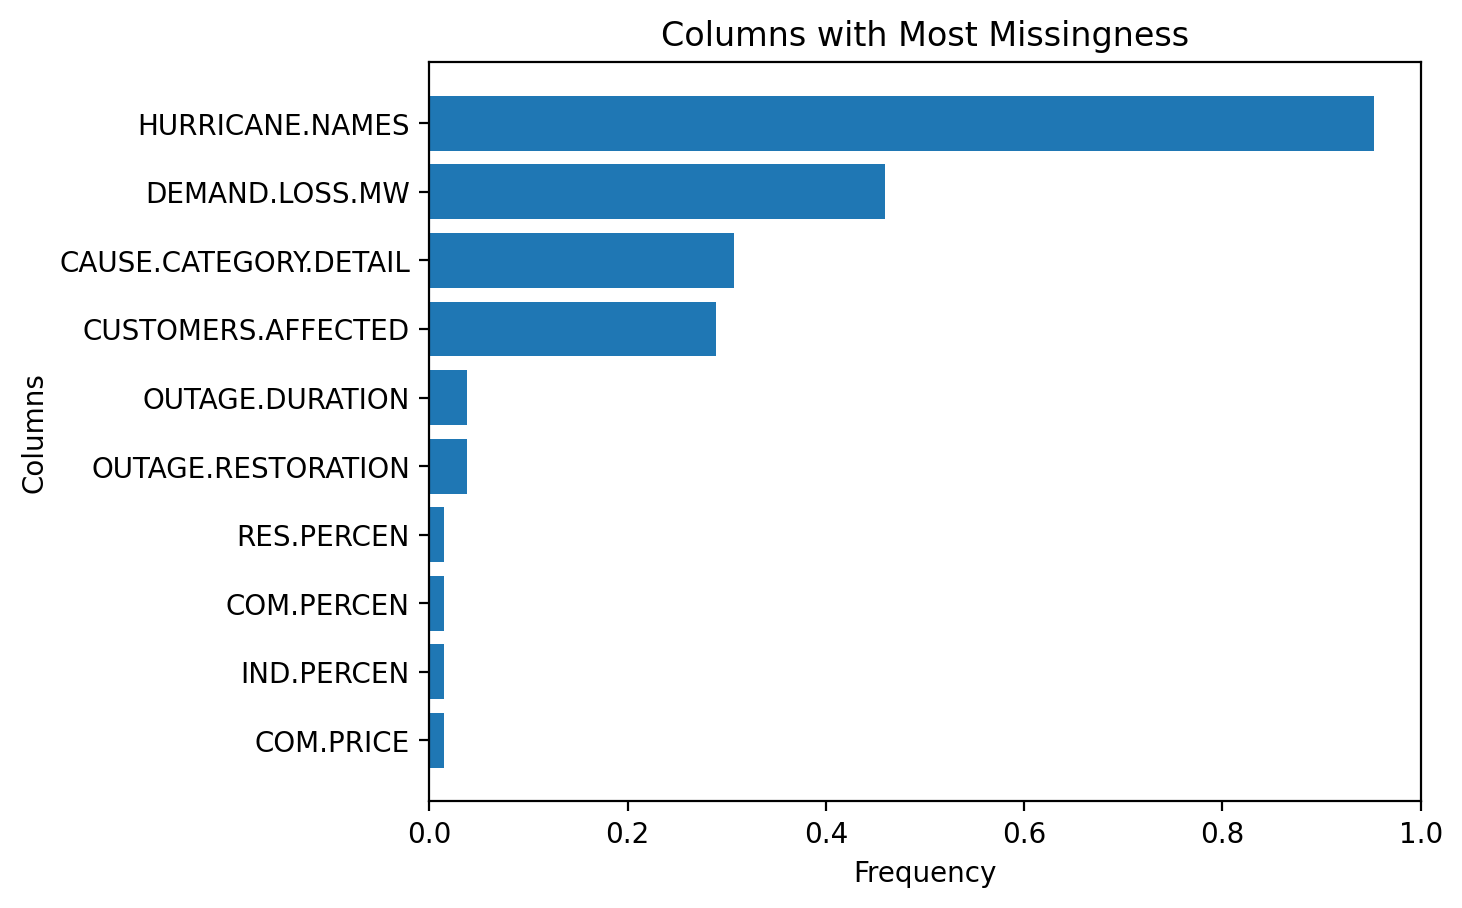

In [17]:
# sorts top missing columns
mostMissing = major.isna().mean().sort_values(ascending = False).head(10).sort_values(ascending = True)
plt.xlabel('Frequency')
plt.ylabel('Columns')
plt.title('Columns with Most Missingness')
plt.barh(mostMissing.index, mostMissing.values)
plt.show()

This histogram shows the outage duration distribution depending on the missingness of demand loss. They have similar means so the KS statistic is helpful.

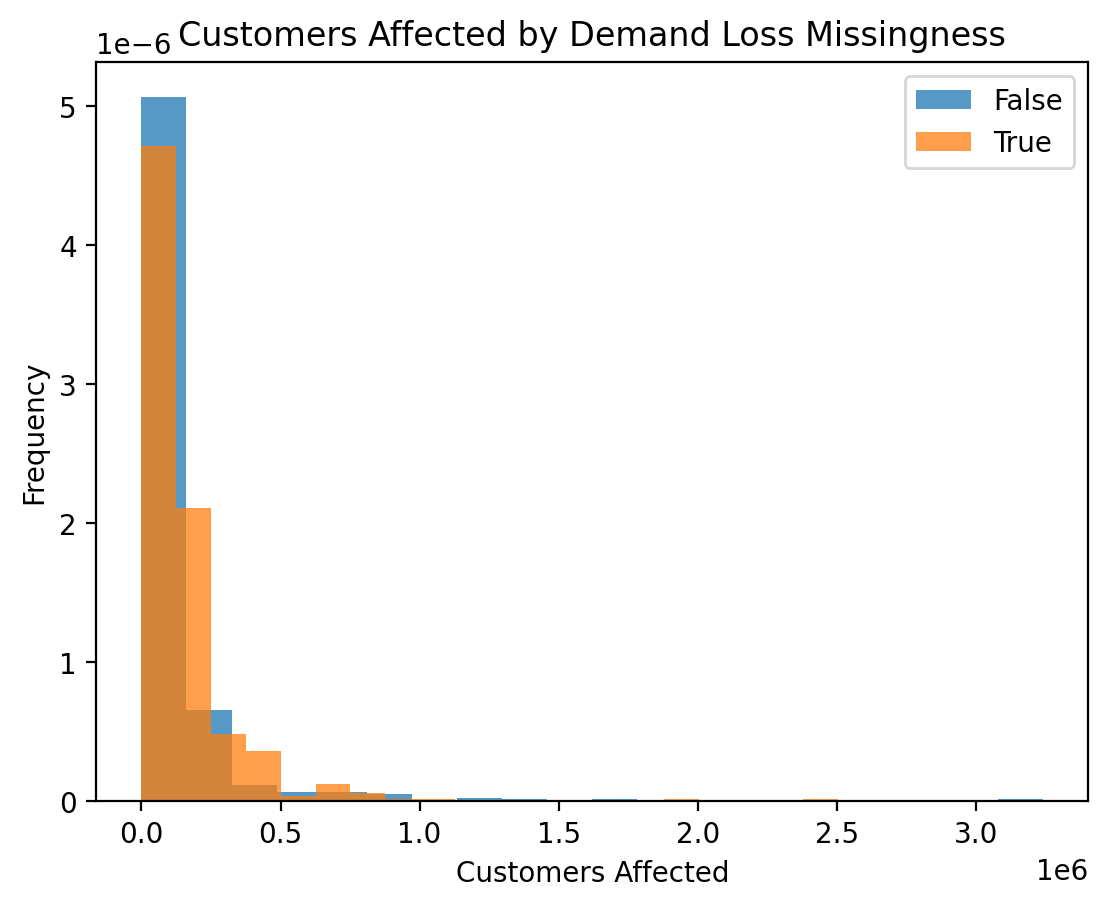

In [18]:
# groups demand loss by null and not null
(major.assign(nullVals = major['DEMAND.LOSS.MW'].isna())
 .groupby('nullVals')['CUSTOMERS.AFFECTED']
 .plot(kind = 'hist', density = True, alpha = 0.75, bins = 20, legend = True, 
       title = 'Customers Affected by Demand Loss Missingness')
)
plt.xlabel('Customers Affected')
plt.show()

This cell uses the KS statistic with alpha = 0.05 to determine if the missingness of Demand Loss depends on Outage Duration. The final p-value is 2.9e-40 which is less than alpha so the durations for null demand loss do not come from the same distribution as the durations for non-null demand loss.

In [19]:
testColumn = 'CUSTOMERS.AFFECTED'
# creates null and not null distributions to run KS test
nullDistr = major[major['DEMAND.LOSS.MW'].isna()][testColumn]
nonnullDistr = major[~major['DEMAND.LOSS.MW'].isna()][testColumn]
ks_2samp(nullDistr, nonnullDistr)[1]

2.927282762833191e-40

This histogram shows the electricity consumption in the industrial sector based on the missingness of demand loss. They have similar means so the KS statistic is helpful.

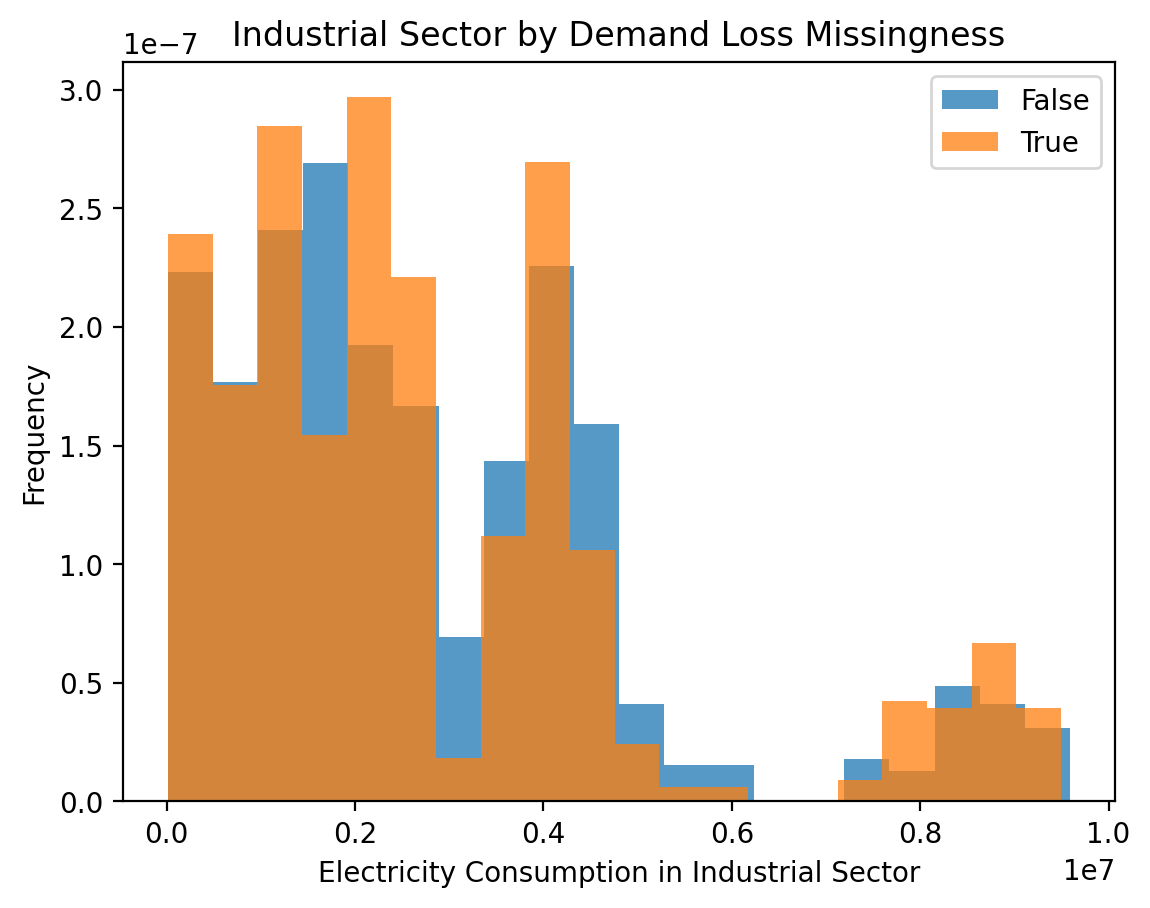

In [20]:
(major.assign(nullVals = major['DEMAND.LOSS.MW'].isna())
 .groupby('nullVals')['IND.SALES']
 .plot(kind = 'hist', density = True, alpha = 0.75, bins = 20, legend = True, 
       title = 'Industrial Sector by Demand Loss Missingness')
)
plt.xlabel('Electricity Consumption in Industrial Sector')
plt.show()

This cell uses the KS statistic with alpha = 0.05 to determine if the missingness of Demand Loss depends on the Instrial Sector sales. The final p-value is 0.18 which is more than alpha so the durations for null demand loss could come from the same distribution as the durations for non-null demand loss.

In [21]:
testColumn = 'IND.SALES'
nullDistr = major[major['DEMAND.LOSS.MW'].isna()][testColumn]
nonnullDistr = major[~major['DEMAND.LOSS.MW'].isna()][testColumn]
ks_2samp(nullDistr, nonnullDistr)[1]

0.1803046468258227

### Hypothesis Test

The hypothesis test I want to run is whether certain regions of the US have a higher proportion of major outages than others with alpha 0.05. This cell compares the observed distribution to a uniform distribution under the null hypothesis. <br>
Null Hypothesis: Major outages are uniformly distributed across regions <br>
Alternative Hypothesis: Major outages are not uniformly distributed across regions

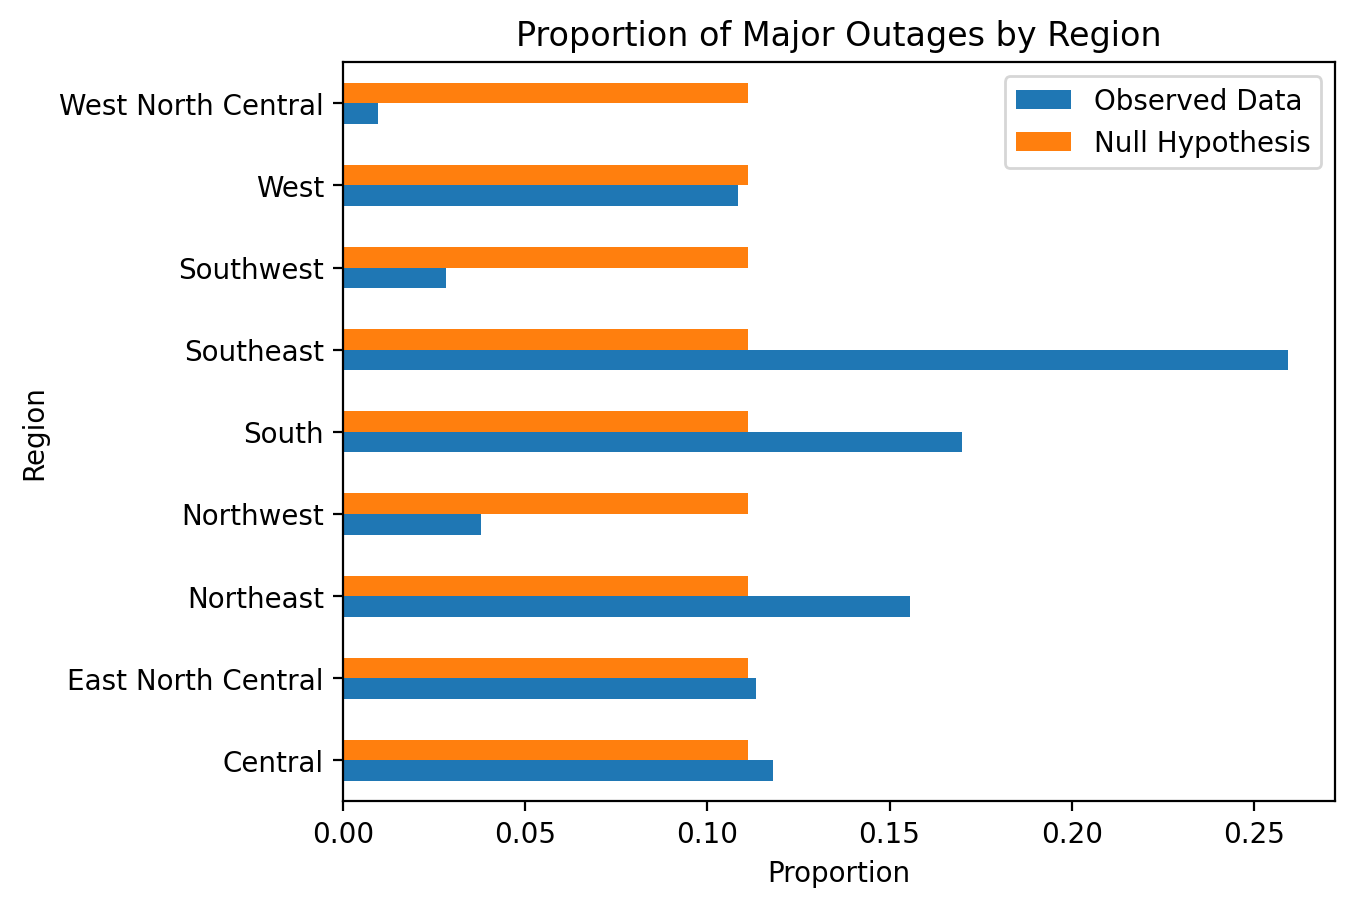

In [22]:
# gets only major outages and groups by region
allMajor = major[major['MAJOR']]
allMajor = allMajor.groupby('CLIMATE.REGION')[['OBS']].count()
allMajor  = allMajor / allMajor.sum()
allMajor = allMajor.rename(columns = {'OBS': 'Observed Data'})
# creates uniform distribution of null hypothesis
allMajor['Null Hypothesis'] = 1 / len(allMajor)
# plots distributions
allMajor.plot(kind = 'barh')
plt.title('Proportion of Major Outages by Region')
plt.xlabel('Proportion')
plt.ylabel('Region')
plt.show()

The TVD is the best statistic for categorical data. This cell finds the observed TVD which is 0.26.

In [23]:
obsTVD = allMajor.diff(axis=1).iloc[:, -1].abs().sum()/2
obsTVD

0.260482180293501

This cell simulates 1,000,000 TVDs under the null hypothesis.

In [24]:
N = 1000000
am = major[major['MAJOR']]
total = am['CLIMATE.REGION'].count()
allUnique = am['CLIMATE.REGION'].nunique()
# creates null distribution
ps = np.full(allUnique, 1/allUnique)
# simulates 1,000,000 times
simulated = np.divide(np.random.multinomial(total, ps, size = N), total)
# finds TVD for each simulation
tvds = (np.abs(simulated - ps)).sum(axis=1) / 2
tvds[:5]

array([0.08595388, 0.0697065 , 0.05974843, 0.0932914 , 0.09800839])

This cell shows the distribution of TVDs with the observed TVD in red. We can tell that the observed TVD is very unlikely under the null hypothesis.

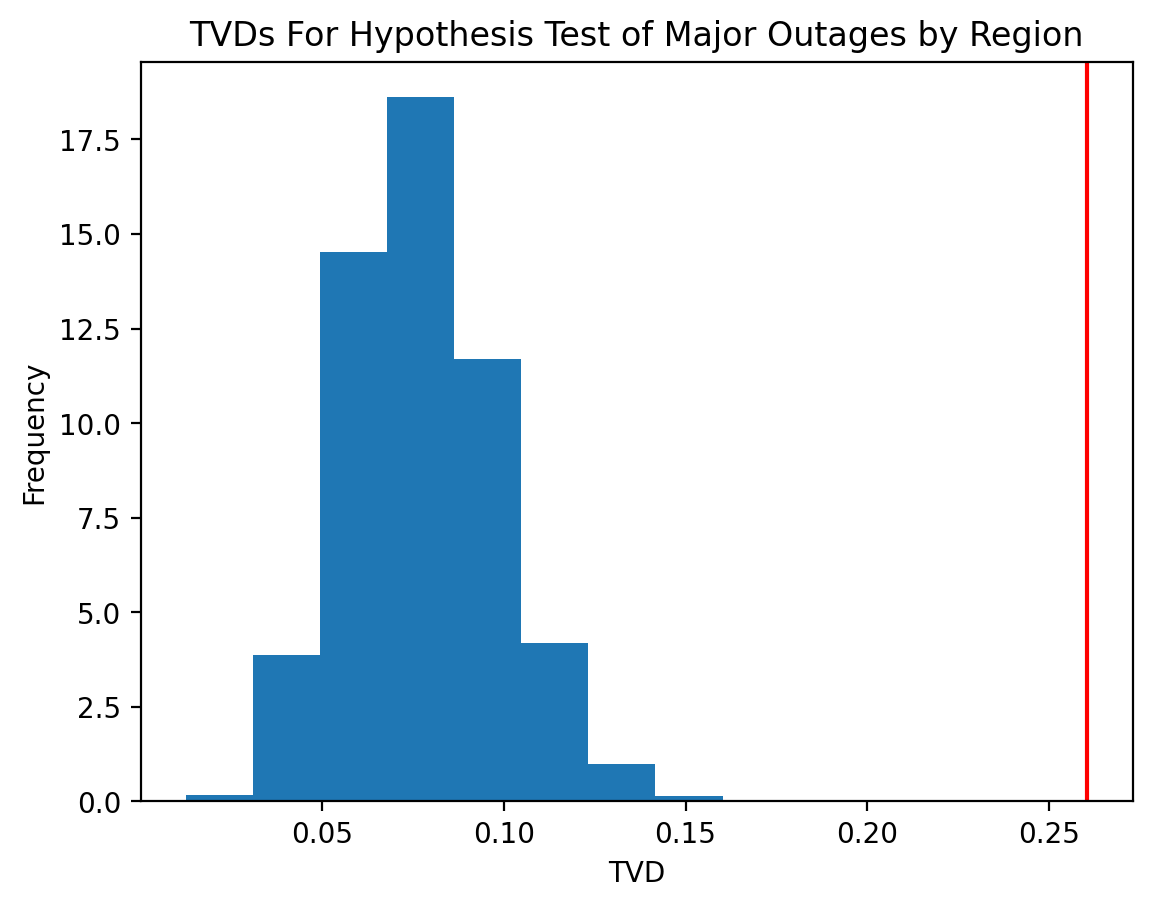

In [25]:
plt.hist(tvds, density = True)
plt.axvline(obsTVD, color = 'red')
plt.xlabel('TVD')
plt.ylabel('Frequency')
plt.title('TVDs For Hypothesis Test of Major Outages by Region')
plt.show()

This cell finds the p value which is 0. Since this is less than alpha, I reject the null hypothesis. There is sufficient evidence that major outages are not uniformly distributed across regions.

In [26]:
np.mean(tvds >= obsTVD)

0.0